In [26]:
import pandas as pd
import os
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

import sys
sys.set_int_max_str_digits(0)

In [27]:
def confidence_interval(data, confidence=0.95):
    # Calculate confidence interval
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2.0, n-1)
    return m-h, m+h

In [30]:
question_numbers = [1, 2, 3, 4, 5, 6, 7, 8]         # Numbers of questions from DASS to run through
target = "anxiety_status"
models_to_train = 10        # Number of models for each number of questions from DASS
models_per_question = 10   # Number of ensembles per model
test_split = 0.1    
seed = 42
random.seed(seed)

ACCS = []
AUCS = []
PRES = []
RECS = []
F1S = []
AUC_STDEV = []
F1_STDEV = []
AUC_95CI_U = []
AUC_95CI_D = []
F1_95CI_U = []
F1_95CI_D = []

data_folder = "./data"
models_folder = "./models"

feats_df = pd.read_csv(os.path.join(data_folder, "features.csv"))
labels_df = pd.read_csv(os.path.join(data_folder, "labels.csv"))

questions = [20, 9, 30, 11, 19, 2, 36, 28, 4, 23]


In [ ]:
for num_questions in question_numbers:
    lst_comb =[]
    
    train_losses = []
    test_losses = []
    if num_questions == 2:
        break
    
    
    for a in range(models_to_train):
        cols = ["gender_m", "gender_f", "region_other", 
                    "region_east", "region_west", "age_norm"]
        if num_questions == 1:  # Only has 1 question
            if a >= len(questions):
                break
            question_nums = [questions[a]]  # a=0, question[0]=20, question_nums contains a list of question numbers
            
        else:  # More than 1 question
            question_nums = random.sample(questions, num_questions)  # Randomly sample num_questions from all questions
            question_nums.sort() # Sort the questions
            #resample if already in list
            while question_nums in lst_comb:
                question_nums = random.sample(questions, num_questions)
            lst_comb.append(question_nums)
        
        for q in question_nums:  # q is one of the selected questions
            for j in range(4):
                cols.append("Q{0}A_{1}".format(q, j))  # Generate the question numbers
        features = feats_df[cols]  # Get the features for the selected questions
        

        labels = labels_df[[target]].copy()
        print("Num Questions: ", num_questions)
        print("Selected questions: ", question_nums, "a: ", a)
        print("features: ", len(features.columns))
        
        np.random.seed(seed)
        shufId = np.random.permutation(int(len(labels)))
        index = int(test_split * len(labels.index))  # Index of data to be used for testing

        df_prist = features.iloc[shufId[0:index]]   # Data for testing
        df_trainvalid = features.iloc[shufId[index:-1]] # Data for training and validation

        gt_prist = labels.iloc[shufId[0:index]]     # Labels for testing
        gt_trainvalid = labels.iloc[shufId[index:-1]]       # Labels for training and validation

        for b in range(models_per_question):
            np.random.seed(b)
            shufId = np.random.permutation(int(len(gt_trainvalid)))
            index = int((1/9) * len(gt_trainvalid.index))

            df_valid = df_trainvalid.iloc[shufId[0:index]]
            df_train = df_trainvalid.iloc[shufId[index:-1]]

            gt_valid = gt_trainvalid.iloc[shufId[0:index]]
            gt_train = gt_trainvalid.iloc[shufId[index:-1]]

            df_valid = df_valid.reset_index(drop=True)
            df_train = df_train.reset_index(drop=True)

            gt_valid = gt_valid.reset_index(drop=True)
            gt_train = gt_train.reset_index(drop=True)

            dataset = {}
            # Convert data to PyTorch tensors and store in dataset
            dataset['train_input'] = torch.from_numpy(df_train.values).float()
            dataset['train_label'] = torch.from_numpy(gt_train.values).float()
            dataset['test_input'] = torch.from_numpy(df_prist.values).float()
            dataset['test_label'] = torch.from_numpy(gt_prist.values).float()
            print("b: ", b)
            print("Train Input Size:", dataset['train_input'].shape)
            print("Train Label Size:", dataset['train_label'].shape)
            model = KAN(width=[dataset['train_input'].size(1),5,1], grid=2, k=3, seed=0)
            
            model(dataset['train_input'])  # obtain activation
            lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
            model.auto_symbolic(lib=lib)
            
            def train_acc(): 
                return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

            def test_acc():
                return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())
            
            results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc))
            formula = model.symbolic_formula()[0][0]
            print(formula)
            
            def acc(formula, X, y):
                batch = X.shape[0]
                correct = 0
                for i in range(batch):
                    formula_eval = formula
                    for j in range(X.size(1)):
                        index = j + 1
                        formula_eval = formula_eval.subs('x_{0}'.format(index), X[i, j].item())
                    correct += (np.round(np.array(formula_eval).astype(np.float64)) == y[i, 0].item())
                return correct / batch

            print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
            print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

            train_losses += results['train_loss']
            test_losses += results['test_loss']
        
    

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import pickle
import torch
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import scipy

# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), scipy.stats.sem(data)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m + h, m - h

# Lists to store final results
ACCS = []
AUCS = []
AUC_STDEV = []
AUC_95CI_U = []
AUC_95CI_D = []
PRES = []
RECS = []
F1S = []
F1_STDEV = []
F1_95CI_U = []
F1_95CI_D = []

# For different numbers of questions from DASS-42
#for num_questions in question_numbers:
num_questions = 9

models = {}

accs = []
aucs = []
pres = []
recs = []
f1s = []
auc_stdev = []
f1_stdev = []
auc_95ci_u = []
auc_95ci_d = []
f1_95ci_u = []
f1_95ci_d = []
lst_comb = []

model_num = 0
for a in range(models_to_train):
    model = {}

    print("Training model", a)
    cols = ["gender_m", "gender_f", "region_other", 
            "region_east", "region_west", "age_norm"]

    if num_questions == 1:
        if a >= len(questions):
            break
        question_nums = [questions[a]]
    else:
        question_nums = random.sample(questions, num_questions)
        question_nums.sort()
        # Resample if already in list
        while question_nums in lst_comb:
            question_nums = random.sample(questions, num_questions)
        lst_comb.append(question_nums)

    for q in question_nums:
        for j in range(4):
            cols.append("Q{0}A_{1}".format(q, j))
    features = feats_df[cols]

    labels = labels_df[[target]].copy()

    np.random.seed(seed)
    shufId = np.random.permutation(int(len(labels)))
    index = int(test_split * len(labels.index))

    df_prist = features.iloc[shufId[0:index]]
    df_trainvalid = features.iloc[shufId[index:-1]]

    gt_prist = labels.iloc[shufId[0:index]]
    gt_trainvalid = labels.iloc[shufId[index:-1]]

    df_prist.to_csv(os.path.join(data_folder, "prist_features.csv"), index=False)
    gt_prist.to_csv(os.path.join(data_folder, "prist_labels.csv"), index=False)

    accs1 = []
    aucs1 = []
    pres1 = []
    recs1 = []
    f1s1 = []
    ensemble_models = []

    for b in range(models_per_question):
        if b % 10 == 0:
            print("Training iteration", b)

        np.random.seed(b)
        shufId = np.random.permutation(int(len(gt_trainvalid)))
        index = int((1/9) * len(gt_trainvalid.index))

        df_valid = df_trainvalid.iloc[shufId[0:index]]
        df_train = df_trainvalid.iloc[shufId[index:-1]]

        gt_valid = gt_trainvalid.iloc[shufId[0:index]]
        gt_train = gt_trainvalid.iloc[shufId[index:-1]]

        df_valid = df_valid.reset_index(drop=True)
        df_train = df_train.reset_index(drop=True)

        gt_valid = gt_valid.reset_index(drop=True)
        gt_train = gt_train.reset_index(drop=True)

        dataset = {}
        dataset['train_input'] = torch.from_numpy(df_train.values).float()
        dataset['train_label'] = torch.from_numpy(gt_train.values).float()
        dataset['test_input'] = torch.from_numpy(df_prist.values).float()
        dataset['test_label'] = torch.from_numpy(gt_prist.values).float()
        clf = KAN(width=[dataset['train_input'].size(1),5,1], grid=2, k=3, seed=0)

        clf(dataset['train_input'])
        lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
        clf.auto_symbolic(lib=lib)

        def train_acc():
            return torch.mean((torch.round(clf(dataset['train_input'])[:, 0]) == dataset['train_label'][:, 0]).float())

        def test_acc():
            return torch.mean((torch.round(clf(dataset['test_input'])[:, 0]) == dataset['test_label'][:, 0]).float())

        results = clf.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc))
        formula = clf.symbolic_formula()[0][0]
        
        def acc(formula, X, y):
            batch = X.shape[0]
            correct = 0
            for i in range(batch):
                formula_eval = formula
                for j in range(X.size(1)):
                    index = j + 1
                    formula_eval = formula_eval.subs('x_{0}'.format(index), X[i, j].item())
                correct += (np.round(np.array(formula_eval).astype(np.float64)) == y[i, 0].item())
            return correct / batch

        train_accuracy = acc(formula, dataset['train_input'], dataset['train_label'])
        test_accuracy = acc(formula, dataset['test_input'], dataset['test_label'])

        accs1.append(test_accuracy)
        # Ensure no NaN values in predictions
        pred_test = torch.round(clf(dataset['test_input'])[:, 0]).detach().numpy()
        pred_test = np.nan_to_num(pred_test)
        auc_score = roc_auc_score(gt_prist, pred_test)
        aucs1.append(auc_score)

    mean_acc1 = np.mean(accs1)
    mean_auc1 = np.mean(aucs1)
    stdev_auc1 = np.std(aucs1)
    ci_auc1_u, ci_auc1_d = confidence_interval(aucs1)
    mean_pre1 = np.mean(pres1)
    mean_rec1 = np.mean(recs1)
    mean_f11 = np.mean(f1s1)
    stdev_f11 = np.std(f1s1)
    ci_f11_u, ci_f11_d = confidence_interval(f1s1)

    accs.append(mean_acc1)
    aucs.append(mean_auc1)
    auc_stdev.append(stdev_auc1)
    auc_95ci_u.append(ci_auc1_u)
    auc_95ci_d.append(ci_auc1_d)
    pres.append(mean_pre1)
    recs.append(mean_rec1)
    f1s.append(mean_f11)
    f1_stdev.append(stdev_f11)
    f1_95ci_u.append(ci_f11_u)
    f1_95ci_d.append(ci_f11_d)

    model["questions"] = question_nums
    model["models"] = ensemble_models
    model["auc_score"] = mean_auc1
    model["f1_score"] = mean_f11

    models[model_num] = model
    model_num += 1

mean_acc = np.mean(accs)
mean_auc = np.mean(aucs)
stdev_auc = np.mean(auc_stdev)
ci_auc_u = np.mean(auc_95ci_u)
ci_auc_d = np.mean(auc_95ci_d)
mean_pre = np.mean(pres)
mean_rec = np.mean(recs)
mean_f1  = np.mean(f1s)
stdev_f1 = np.mean(f1_stdev)
ci_f1_u = np.mean(f1_95ci_u)
ci_f1_d = np.mean(f1_95ci_d)

percentile_list = pd.DataFrame(
{
    'accuracy': accs,
    'auc_roc': aucs,
    'auc_stdev': auc_stdev,
    'auc_95ci_u': auc_95ci_u,
    'auc_95ci_d': auc_95ci_d,
    'precision': pres,
    'recall': recs,
    'f1_score': f1s,
    'f1_stdev': f1_stdev,
    'f1_95ci_u': f1_95ci_u,
    'f1_95ci_d': f1_95ci_d,
})
percentile_list.to_csv


Training model 0
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.49e-01 | test loss: 2.51e-01 | reg: 3.34e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.43e-01 | test loss: 2.70e-01 | reg: 3.57e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.48e-01 | test loss: 2.77e-01 | reg: 3.55e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.32e-01 | test loss: 2.72e-01 | reg: 4.44e+01 : 100%|██| 20/20 [00:21<00:00,  1.08s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.30e-01 | test loss: 2.67e-01 | reg: 4.07e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.27e-01 | test loss: 2.77e-01 | reg: 5.37e+01 : 100%|██| 20/20 [00:21<00:00,  1.06s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.37e-01 | test loss: 2.79e-01 | reg: 3.67e+01 : 100%|██| 20/20 [00:15<00:00,  1.26it/s]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.25e-01 | test loss: 2.72e-01 | reg: 4.44e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.38e-01 | test loss: 2.74e-01 | reg: 4.52e+01 : 100%|██| 20/20 [00:26<00:00,  1.35s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.10e-01 | test loss: 2.51e-01 | reg: 4.34e+01 : 100%|██| 20/20 [00:23<00:00,  1.18s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 1
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.25e-01 | test loss: 2.60e-01 | reg: 4.15e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.26e-01 | test loss: 2.73e-01 | reg: 4.80e+01 : 100%|██| 20/20 [00:22<00:00,  1.15s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.38e-01 | test loss: 2.51e-01 | reg: 3.51e+01 : 100%|██| 20/20 [00:20<00:00,  1.04s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.13e-01 | test loss: 2.46e-01 | reg: 4.61e+01 : 100%|██| 20/20 [00:23<00:00,  1.16s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.37e-01 | test loss: 2.69e-01 | reg: 3.84e+01 : 100%|██| 20/20 [00:23<00:00,  1.19s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.29e-01 | test loss: 2.64e-01 | reg: 4.60e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.26e-01 | test loss: 2.57e-01 | reg: 4.35e+01 : 100%|██| 20/20 [00:23<00:00,  1.15s/it]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.10e-01 | test loss: 2.61e-01 | reg: 4.54e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.43e-01 | test loss: 2.72e-01 | reg: 3.68e+01 : 100%|██| 20/20 [00:23<00:00,  1.16s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.23e-01 | test loss: 2.92e-01 | reg: 5.34e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 2
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.33e-01 | test loss: 2.67e-01 | reg: 3.94e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.23e-01 | test loss: 2.64e-01 | reg: 5.44e+01 : 100%|██| 20/20 [00:22<00:00,  1.10s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.18e-01 | test loss: 2.54e-01 | reg: 3.88e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.35e-01 | test loss: 2.55e-01 | reg: 4.38e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.42e-01 | test loss: 3.03e-01 | reg: 4.23e+01 : 100%|██| 20/20 [00:23<00:00,  1.18s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.12e-01 | test loss: 2.35e-01 | reg: 5.80e+01 : 100%|██| 20/20 [00:23<00:00,  1.15s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.26e-01 | test loss: 2.84e-01 | reg: 4.70e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.48e-01 | test loss: 2.84e-01 | reg: 3.66e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.26e-01 | test loss: 2.71e-01 | reg: 4.00e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.42e-01 | test loss: 2.61e-01 | reg: 4.09e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 3
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.24e-01 | test loss: 2.75e-01 | reg: 3.90e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.19e-01 | test loss: 2.69e-01 | reg: 3.69e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.39e-01 | test loss: 2.73e-01 | reg: 3.52e+01 : 100%|██| 20/20 [00:19<00:00,  1.05it/s]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.11e-01 | test loss: 2.25e-01 | reg: 4.16e+01 : 100%|██| 20/20 [00:27<00:00,  1.36s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.33e-01 | test loss: 2.85e-01 | reg: 3.92e+01 : 100%|██| 20/20 [00:26<00:00,  1.31s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.15e-01 | test loss: 2.52e-01 | reg: 3.86e+01 : 100%|██| 20/20 [00:25<00:00,  1.27s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.07e-01 | test loss: 2.39e-01 | reg: 4.00e+01 : 100%|██| 20/20 [00:26<00:00,  1.32s/it]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.15e-01 | test loss: 2.73e-01 | reg: 4.35e+01 : 100%|██| 20/20 [00:26<00:00,  1.33s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.27e-01 | test loss: 2.69e-01 | reg: 5.08e+01 : 100%|██| 20/20 [00:24<00:00,  1.24s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.24e-01 | test loss: 2.73e-01 | reg: 4.48e+01 : 100%|██| 20/20 [00:25<00:00,  1.28s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 4
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.19e-01 | test loss: 2.66e-01 | reg: 4.17e+01 : 100%|██| 20/20 [00:26<00:00,  1.31s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.57e-01 | test loss: 2.62e-01 | reg: 3.65e+01 : 100%|██| 20/20 [00:20<00:00,  1.00s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.55e-01 | test loss: 2.73e-01 | reg: 3.33e+01 : 100%|██| 20/20 [00:27<00:00,  1.37s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.32e-01 | test loss: 2.82e-01 | reg: 4.69e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.47e-01 | test loss: 2.85e-01 | reg: 3.46e+01 : 100%|██| 20/20 [00:21<00:00,  1.09s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.52e-01 | test loss: 2.93e-01 | reg: 3.61e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.33e-01 | test loss: 2.75e-01 | reg: 3.70e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.15e-01 | test loss: 2.74e-01 | reg: 4.86e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.39e-01 | test loss: 2.93e-01 | reg: 4.08e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.28e-01 | test loss: 2.70e-01 | reg: 4.15e+01 : 100%|██| 20/20 [00:23<00:00,  1.16s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 5
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.45e-01 | test loss: 2.28e-01 | reg: 3.59e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.30e-01 | test loss: 2.71e-01 | reg: 4.03e+01 : 100%|██| 20/20 [00:21<00:00,  1.10s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.46e-01 | test loss: 2.75e-01 | reg: 3.38e+01 : 100%|██| 20/20 [00:22<00:00,  1.15s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.40e-01 | test loss: 2.80e-01 | reg: 4.26e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.46e-01 | test loss: 2.90e-01 | reg: 4.52e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.28e-01 | test loss: 2.70e-01 | reg: 4.39e+01 : 100%|██| 20/20 [00:21<00:00,  1.10s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.39e-01 | test loss: 2.57e-01 | reg: 4.07e+01 : 100%|██| 20/20 [00:16<00:00,  1.20it/s]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.23e-01 | test loss: 2.73e-01 | reg: 7.02e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.30e-01 | test loss: 2.74e-01 | reg: 3.73e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.18e-01 | test loss: 2.74e-01 | reg: 4.30e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 6
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.46e-01 | test loss: 2.45e-01 | reg: 3.75e+01 : 100%|██| 20/20 [00:23<00:00,  1.15s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.20e-01 | test loss: 2.58e-01 | reg: 4.75e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.38e-01 | test loss: 2.53e-01 | reg: 3.52e+01 : 100%|██| 20/20 [00:22<00:00,  1.11s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.30e-01 | test loss: 2.88e-01 | reg: 4.13e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.17e-01 | test loss: 2.65e-01 | reg: 5.27e+01 : 100%|██| 20/20 [00:22<00:00,  1.10s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.26e-01 | test loss: 2.53e-01 | reg: 4.44e+01 : 100%|██| 20/20 [00:21<00:00,  1.09s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.64e-01 | test loss: 2.86e-01 | reg: 3.27e+01 : 100%|██| 20/20 [00:11<00:00,  1.72it/s]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.06e-01 | test loss: 2.64e-01 | reg: 4.92e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.31e-01 | test loss: 2.77e-01 | reg: 5.04e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.27e-01 | test loss: 2.70e-01 | reg: 5.09e+01 : 100%|██| 20/20 [00:21<00:00,  1.08s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 7
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.25e-01 | test loss: 2.52e-01 | reg: 4.57e+01 : 100%|██| 20/20 [00:21<00:00,  1.09s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.43e-01 | test loss: 2.62e-01 | reg: 3.70e+01 : 100%|██| 20/20 [00:23<00:00,  1.15s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.07e-01 | test loss: 2.43e-01 | reg: 5.97e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.22e-01 | test loss: 2.65e-01 | reg: 3.71e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.12e-01 | test loss: 2.53e-01 | reg: 4.30e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.18e-01 | test loss: 2.42e-01 | reg: 5.07e+01 : 100%|██| 20/20 [00:21<00:00,  1.08s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.32e-01 | test loss: 2.80e-01 | reg: 4.06e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.18e-01 | test loss: 2.71e-01 | reg: 4.25e+01 : 100%|██| 20/20 [00:23<00:00,  1.16s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.29e-01 | test loss: 2.91e-01 | reg: 4.14e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.08e-01 | test loss: 2.75e-01 | reg: 5.22e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 8
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.22e-01 | test loss: 2.88e-01 | reg: 8.54e+01 : 100%|██| 20/20 [00:23<00:00,  1.15s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.21e-01 | test loss: 2.63e-01 | reg: 7.63e+01 : 100%|██| 20/20 [00:21<00:00,  1.10s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.18e-01 | test loss: 2.33e-01 | reg: 4.37e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.06e-01 | test loss: 2.49e-01 | reg: 5.53e+01 : 100%|██| 20/20 [00:21<00:00,  1.07s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.21e-01 | test loss: 3.10e-01 | reg: 5.84e+01 : 100%|██| 20/20 [00:22<00:00,  1.10s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 1.94e-01 | test loss: 2.58e-01 | reg: 6.30e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.23e-01 | test loss: 2.34e-01 | reg: 5.93e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.22e-01 | test loss: 2.55e-01 | reg: 6.37e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.32e-01 | test loss: 2.79e-01 | reg: 4.28e+01 : 100%|██| 20/20 [00:17<00:00,  1.17it/s]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.12e-01 | test loss: 2.44e-01 | reg: 7.67e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

Training model 9
Training iteration 0
fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000018
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.000000000000002
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.000000000000002
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000029
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000029
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp,

train loss: 2.23e-01 | test loss: 2.67e-01 | reg: 4.82e+01 : 100%|██| 20/20 [00:23<00:00,  1.19s/it]


fixing (0,0,0) with x^4, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000013
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000018
fixing (0,1,1) with exp, r2=1.0000000000000013
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000018
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000018
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.11e-01 | test loss: 2.55e-01 | reg: 4.49e+01 : 100%|██| 20/20 [00:23<00:00,  1.16s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000002
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000018
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000016
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) w

train loss: 2.54e-01 | test loss: 2.99e-01 | reg: 4.21e+01 : 100%|██| 20/20 [00:23<00:00,  1.19s/it]


fixing (0,0,0) with exp, r2=1.0000000000000018
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000013
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000016
fixing (0,2,0) with exp, r2=1.000000000000002
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000013
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000027
fixing (0,3,1) with exp, r2=1.0000000000000036
fixing (0,3,2) with exp, r2=1.0000000000000036
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.000000000000003
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) 

train loss: 2.43e-01 | test loss: 2.69e-01 | reg: 3.83e+01 : 100%|██| 20/20 [00:23<00:00,  1.17s/it]


fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.000000000000001
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with x^4, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000013
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.0000000000000016
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000013
fixing (0,3,2) with exp, r2=1.000000000000002
fixing (0,3,3) with exp, r2=1.0000000000000018
fixing (0,3,4) with exp, r2=1.0000000000000016
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.25e-01 | test loss: 2.65e-01 | reg: 4.67e+01 : 100%|██| 20/20 [00:21<00:00,  1.09s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.000000000000002
fixing (0,2,0) with exp, r2=1.0000000000000018
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000013
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000016
fixing (0,3,1) with exp, r2=1.0000000000000018
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.000000000000002
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000016
fixing (0,4,1) 

train loss: 2.00e-01 | test loss: 2.53e-01 | reg: 5.69e+01 : 100%|██| 20/20 [00:22<00:00,  1.13s/it]


fixing (0,0,0) with exp, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with x^4, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000016
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000016
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.000000000000001
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.000000000000001
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with x^4, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000029
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000024
fixing (0,3,4) with exp, r2=1.0000000000000029
fixing (0,4,0) with exp, r2=1.0000000000000013
fixing (0,4,1) wi

train loss: 2.38e-01 | test loss: 2.92e-01 | reg: 5.78e+01 : 100%|██| 20/20 [00:22<00:00,  1.15s/it]


fixing (0,0,0) with x^4, r2=1.000000000000002
fixing (0,0,1) with x^4, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.000000000000002
fixing (0,0,3) with exp, r2=1.0000000000000018
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000013
fixing (0,2,2) with exp, r2=1.000000000000001
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.000000000000002
fixing (0,3,1) with exp, r2=1.000000000000002
fixing (0,3,2) with exp, r2=1.0000000000000018
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.000000000000002
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1) with

train loss: 2.73e-01 | test loss: 2.87e-01 | reg: 3.35e+01 : 100%|██| 20/20 [00:11<00:00,  1.71it/s]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with exp, r2=1.0000000000000013
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000016
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=1.0000000000000013
fixing (0,2,1) with exp, r2=1.0000000000000016
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000013
fixing (0,3,0) with exp, r2=1.0000000000000018
fixing (0,3,1) with exp, r2=1.0000000000000024
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000022
fixing (0,3,4) with exp, r2=1.0000000000000022
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.30e-01 | test loss: 2.52e-01 | reg: 4.47e+01 : 100%|██| 20/20 [00:23<00:00,  1.16s/it]


fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with x^4, r2=1.0000000000000016
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000013
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with exp, r2=1.0000000000000016
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) with exp, r2=1.0000000000000018
fixing (0,2,2) with exp, r2=1.0000000000000018
fixing (0,2,3) with exp, r2=1.0000000000000016
fixing (0,2,4) with exp, r2=1.0000000000000016
fixing (0,3,0) with exp, r2=1.0000000000000024
fixing (0,3,1) with exp, r2=1.0000000000000027
fixing (0,3,2) with exp, r2=1.0000000000000022
fixing (0,3,3) with exp, r2=1.0000000000000029
fixing (0,3,4) with exp, r2=1.0000000000000024
fixing (0,4,0) with exp, r2=1.0000000000000018
fixing (0,4,1

train loss: 2.14e-01 | test loss: 2.53e-01 | reg: 6.02e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divid

<bound method NDFrame.to_csv of    accuracy   auc_roc  auc_stdev  auc_95ci_u  auc_95ci_d  precision  recall  \
0  0.591304  0.915365   0.016035    0.927456    0.903274        NaN     NaN   
1  0.583696  0.918087   0.017672    0.931413    0.904762        NaN     NaN   
2  0.530435  0.905492   0.016097    0.917631    0.893354        NaN     NaN   
3  0.585870  0.918655   0.017085    0.931538    0.905772        NaN     NaN   
4  0.514130  0.905777   0.014568    0.916761    0.894792        NaN     NaN   
5  0.548913  0.920857   0.017131    0.933775    0.907939        NaN     NaN   
6  0.540217  0.911932   0.018205    0.925660    0.898204        NaN     NaN   
7  0.566304  0.913920   0.022914    0.931199    0.896642        NaN     NaN   
8  0.545652  0.910985   0.023017    0.928341    0.893629        NaN     NaN   
9  0.540217  0.904877   0.018726    0.918997    0.890757        NaN     NaN   

   f1_score  f1_stdev  f1_95ci_u  f1_95ci_d  
0       NaN       NaN        NaN        NaN  
1     

In [17]:
# Assuming labels_df is your DataFrame containing the target column
target_column = target  # Replace with the actual name of your target column

# Get the unique values in the target column
severity_classes = labels_df[target_column].unique()

# Print the severity classes
print("Severity Classes:", severity_classes)

# Number of severity classes
num_severity_classes = len(severity_classes)
print("Number of Severity Classes:", num_severity_classes)

Severity Classes: [1 0]
Number of Severity Classes: 2


In [34]:
# Print results
print("\nAll accuracies:", ACCS)
print("All AUCs:", AUCS)
print("Stdev of AUCs:", AUC_STDEV)
print("95th CI of AUCs:", AUC_95CI_U)
print("95th CI of AUCs:", AUC_95CI_D)
print("All precisions:", PRES)
print("All recalls:", RECS)
print("All F1s:", F1S)
print("Stdev of F1s:", F1_STDEV)
print("95th CI of F1s:", F1_95CI_U)
print("95th CI of F1s:", F1_95CI_D)


All accuracies: []
All AUCs: []
Stdev of AUCs: []
95th CI of AUCs: []
95th CI of AUCs: []
All precisions: []
All recalls: []
All F1s: []
Stdev of F1s: []
95th CI of F1s: []
95th CI of F1s: []


ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

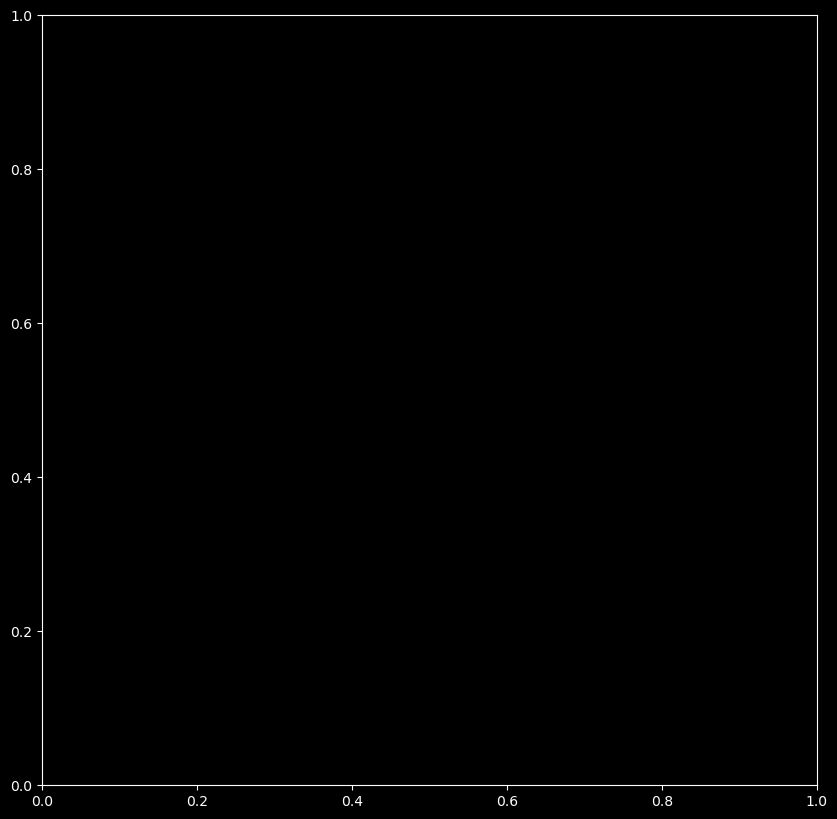

In [35]:
# Plot accuracy results
plt.figure(figsize=(10,10)) # Make new figure
plt.plot(question_numbers, ACCS)
plt.plot(question_numbers, AUCS)
plt.plot(question_numbers, F1S)
plt.plot(question_numbers, PRES)
plt.plot(question_numbers, RECS)
plt.xlabel("Number of DASS questions")
plt.ylabel("Accuracy")
plt.legend(["Accuracy score", "AUC ROC score", "F1 score", "Precision", "Recall"])
plt.show()